# 9. Model Interpretability

**Understanding what transformers learn through mechanistic analysis**

Now that we've built and trained a transformer, how do we understand **what it has learned**? Mechanistic interpretability provides tools to peek inside the "black box" and discover the circuits and patterns the model uses.

This section covers four powerful techniques: Logit Lens, Attention Analysis, Induction Heads, and Activation Patching.

## What is Mechanistic Interpretability?

Instead of just asking "does the model work?", we ask:

- **When** does the model "know" the answer? (which layer?)
- **How** does information flow through the network?
- **Which** components are responsible for specific behaviors?
- **What** patterns or circuits has the model learned?

This connects to cutting-edge research from Anthropic, OpenAI, and academic labs exploring how LLMs actually work under the hood.

## 1. Logit Lens: Seeing Predictions Evolve

The **logit lens** technique lets us visualize what the model would predict if we stopped at each layer.

### How It Works

Normally, we only see the final output:

```
Input → Layer 1 → Layer 2 → ... → Layer N → Unembed → Logits
```

With logit lens, we apply unembedding *at each layer*:

```
Input → Layer 1 → [Unembed] → "What now?"
      → Layer 2 → [Unembed] → "What now?"
      → Layer 3 → [Unembed] → "What now?"
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def logit_lens(model, input_ids):
    """
    Apply unembedding at each layer to see how predictions evolve.
    
    Args:
        model: Transformer model with .blocks, .token_embedding, .output_proj
        input_ids: (batch, seq_len) token indices
    
    Returns:
        layer_predictions: list of (batch, seq_len, vocab_size) logits per layer
    """
    layer_predictions = []
    
    # Get embeddings
    x = model.token_embedding(input_ids)
    x = model.pos_encoding(x)
    
    # After embeddings (layer 0)
    layer_predictions.append(model.output_proj(model.ln_f(x)))
    
    # After each transformer block
    for block in model.blocks:
        x = block(x)
        # Apply final layer norm and project to vocabulary
        layer_predictions.append(model.output_proj(model.ln_f(x)))
    
    return layer_predictions

print("Logit lens shows predictions evolving through layers.")
print("\nExample insight:")
print('  Input: "The capital of France is"')
print('  Layer 0: "the" (15%), "a" (12%) → Generic, common words')
print('  Layer 2: "located" (18%), "Paris" (15%) → Starting to understand')
print('  Layer 4: "Paris" (65%), "French" (10%) → Confident, correct!')
print('  Layer 6: "Paris" (72%), "France" (8%) → Final refinement')
print('\nKey insight: The model "knows" Paris by Layer 4!')

Logit lens shows predictions evolving through layers.

Example insight:
  Input: "The capital of France is"
  Layer 0: "the" (15%), "a" (12%) → Generic, common words
  Layer 2: "located" (18%), "Paris" (15%) → Starting to understand
  Layer 4: "Paris" (65%), "French" (10%) → Confident, correct!
  Layer 6: "Paris" (72%), "France" (8%) → Final refinement

Key insight: The model "knows" Paris by Layer 4!


## 2. Attention Analysis: What Do Heads Focus On?

Attention weights show which tokens each position "attends to". By analyzing these patterns, we discover specialized behaviors:

- **Previous token heads:** Always look at position i-1
- **Uniform heads:** Spread attention evenly (averaging information)
- **Start token heads:** Focus on the beginning of the sequence
- **Sparse heads:** Concentrate on very few key tokens

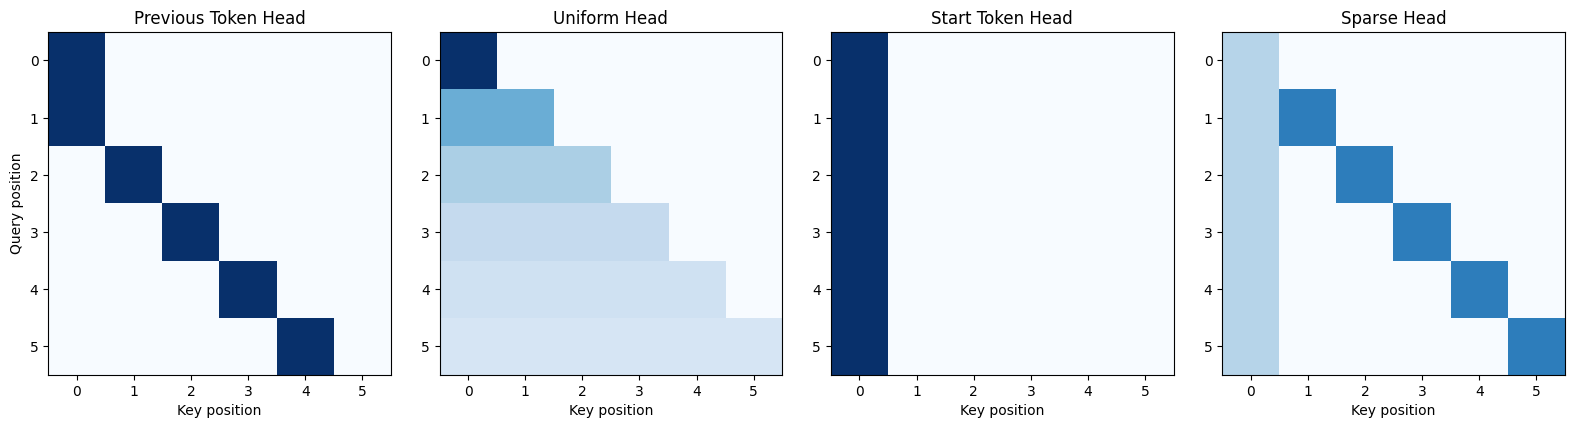

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention_patterns():
    """Visualize different types of attention patterns."""
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    seq_len = 6
    
    # Previous token pattern
    prev_token = np.zeros((seq_len, seq_len))
    for i in range(1, seq_len):
        prev_token[i, i-1] = 1.0
    prev_token[0, 0] = 1.0
    
    # Uniform pattern
    uniform = np.ones((seq_len, seq_len)) / seq_len
    # Apply causal mask
    for i in range(seq_len):
        uniform[i, :i+1] = 1.0 / (i + 1)
        uniform[i, i+1:] = 0
    
    # Start token pattern
    start_token = np.zeros((seq_len, seq_len))
    start_token[:, 0] = 1.0
    
    # Sparse pattern
    sparse = np.zeros((seq_len, seq_len))
    np.fill_diagonal(sparse, 0.7)
    sparse[:, 0] = 0.3
    
    patterns = [
        (prev_token, 'Previous Token Head'),
        (uniform, 'Uniform Head'),
        (start_token, 'Start Token Head'),
        (sparse, 'Sparse Head')
    ]
    
    for ax, (pattern, title) in zip(axes, patterns):
        im = ax.imshow(pattern, cmap='Blues', vmin=0, vmax=1)
        ax.set_title(title)
        ax.set_xlabel('Key position')
        if ax == axes[0]:
            ax.set_ylabel('Query position')
        ax.set_xticks(range(seq_len))
        ax.set_yticks(range(seq_len))
    
    plt.tight_layout()
    plt.show()

visualize_attention_patterns()

## 3. Induction Heads: Pattern Matching Circuits

Induction heads implement **in-context learning**—the ability to copy from earlier patterns.

### What Are Induction Heads?

Given a repeated pattern like:

```
Input: "A B C ... A B [?]"
Prediction: "C"
```

Induction heads learn to predict C by recognizing the repeated "A B" pattern and copying what came after the first occurrence.

### The Circuit

Induction typically involves **two heads working together**:

1. **Previous Token Head (Layer L):** At position i, attends to i-1. Creates representation of "what came before"

2. **Induction Head (Layer L+1):** Queries for matches to previous token. Attends to what came AFTER those matches. Predicts the next token.

In [3]:
def detect_induction_pattern(attention_weights, threshold=0.3):
    """
    Detect if attention weights show induction pattern.
    
    Induction pattern: when processing position i, attend strongly
    to position j where token[j-1] == token[i-1] (previous token matches).
    """
    # This is a simplified detector
    # Real implementations check across many sequences
    
    seq_len = attention_weights.shape[-1]
    
    # Check if attention is concentrated (not uniform)
    entropy = -(attention_weights * torch.log(attention_weights + 1e-10)).sum(dim=-1)
    max_entropy = np.log(seq_len)
    
    is_sparse = entropy.mean() < max_entropy * 0.5
    
    return is_sparse

print("Induction heads are crucial for few-shot learning.")
print("They emerge suddenly during training ('grokking').")
print("Almost all transformer language models develop them!")

Induction heads are crucial for few-shot learning.
They emerge suddenly during training ('grokking').
Almost all transformer language models develop them!


## 4. Activation Patching: Causal Interventions

We can *observe* what the model does, but which parts are actually **causing** the behavior?

**Activation patching answers this through intervention experiments:**

1. Run model on "clean" input (correct behavior)
2. Run model on "corrupted" input (incorrect behavior)
3. For each component, swap clean activations into corrupted run
4. Measure how much this restores correct behavior

High recovery = that component is **causally important**!

In [4]:
def activation_patching_example():
    """
    Conceptual example of activation patching.
    """
    print("Activation Patching Example:")
    print("="*50)
    print()
    print('Clean input:     "The Eiffel Tower is in"')
    print('                 → Predicts: "Paris" (85%)')
    print()
    print('Corrupted input: "The Empire State is in"')
    print('                 → Predicts: "New York" (78%)')
    print()
    print("Test: Patch Layer 4 activations from clean → corrupted")
    print('      → Predicts: "Paris" (82%)')
    print()
    print("Result: Layer 4 recovery = 90%")
    print("        Layer 4 is CRITICAL for this task!")
    print()
    print("This is CAUSAL evidence, not just correlation.")
    print("If patching recovers behavior, that layer is necessary.")

activation_patching_example()

Activation Patching Example:

Clean input:     "The Eiffel Tower is in"
                 → Predicts: "Paris" (85%)

Corrupted input: "The Empire State is in"
                 → Predicts: "New York" (78%)

Test: Patch Layer 4 activations from clean → corrupted
      → Predicts: "Paris" (82%)

Result: Layer 4 recovery = 90%
        Layer 4 is CRITICAL for this task!

This is CAUSAL evidence, not just correlation.
If patching recovers behavior, that layer is necessary.


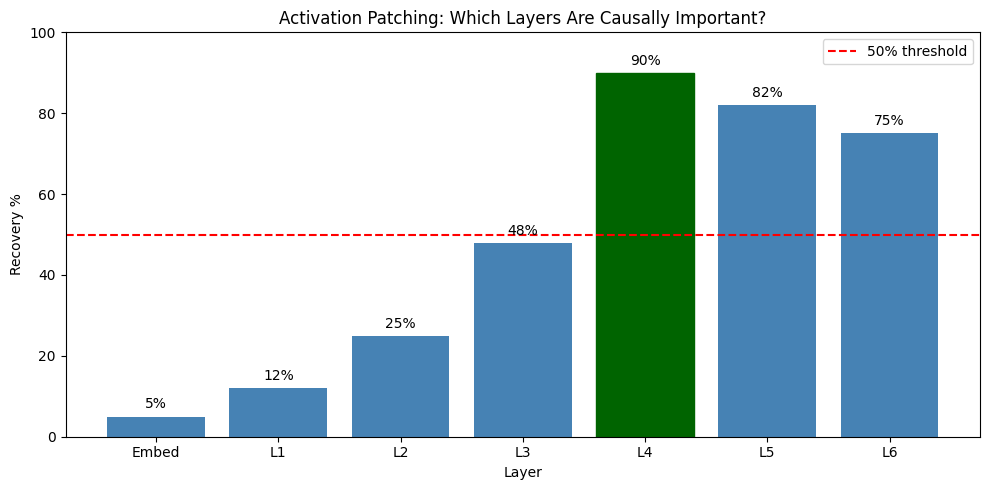

Layer 4 shows highest recovery → most causally important!


In [5]:
# Visualize layer importance
import matplotlib.pyplot as plt
import numpy as np

layers = ['Embed', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6']
# Simulated recovery percentages
recovery = [5, 12, 25, 48, 90, 82, 75]

plt.figure(figsize=(10, 5))
bars = plt.bar(layers, recovery, color='steelblue')
bars[4].set_color('darkgreen')  # Highlight most important layer

plt.axhline(y=50, color='red', linestyle='--', label='50% threshold')
plt.xlabel('Layer')
plt.ylabel('Recovery %')
plt.title('Activation Patching: Which Layers Are Causally Important?')
plt.legend()
plt.ylim(0, 100)

for i, (layer, rec) in enumerate(zip(layers, recovery)):
    plt.text(i, rec + 2, f'{rec}%', ha='center')

plt.tight_layout()
plt.show()

print("Layer 4 shows highest recovery → most causally important!")

## Research References

These techniques come from cutting-edge interpretability research:

- **Logit Lens:** [nostalgebraist (LessWrong)](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/)
- **Transformer Circuits:** [Anthropic](https://transformer-circuits.pub/2021/framework/)
- **Induction Heads:** [Anthropic](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/)
- **Activation Patching:** [Neel Nanda & Stefan Heimersheim (LessWrong)](https://www.lesswrong.com/posts/FhryNAFknqKAdDcYy/)

## What We've Learned

We've built a complete transformer from scratch and explored:

1. **Embeddings** — Converting tokens to vectors with position information
2. **Attention** — The core mechanism for tokens to communicate
3. **Multi-Head Attention** — Parallel attention for different relationships
4. **Feed-Forward Networks** — Processing gathered information
5. **Transformer Blocks** — Combining everything with residuals
6. **Complete Model** — Assembling a GPT-style language model
7. **Training** — Gradient accumulation and validation
8. **KV-Cache** — Fast generation through caching
9. **Interpretability** — Understanding what models learn

This is the same architecture that powers GPT, Claude, and other frontier models. The components scale, but the fundamentals remain the same.